<a href="https://colab.research.google.com/github/mplatt27/Language-Model-Linguistic-Doubling-Task/blob/main/LanguageModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Character-level English Language Model

*Langauge and Mind Lab*


All code is adapted from the book: Natural Language Processing with PyTorch: Build Intelligent Language Applications Using Deep Learning, by Delip Rao and Brian McMahan. The original code is available here: https://github.com/joosthub/PyTorchNLPBook. 

The model uses a Gated Recurrent Unit (GRU) neural network and is trained on a set of ### English words from "". We then evaluate the model with a test set of novel words that both have and do not have linguistic doubling, to determine if the model has learned preferences that are observed in English speakers. We can also generate novel words and look for features like linguistic doubling. 

Notes on dataset:

*   Retrieved from https://www.kaggle.com/rtatman/english-word-frequency and contains 333,333 unique words.
*   I first shuffled the words in the spreadsheet, then took the first ~10,000 words to use (the original code uses a smaller dataset around this size, so as a first attempt on this project, I used a shortened version of the word dataset). We can increase this size later if we want
*   I then labeled approximatley 70% as the training set, 15% as the validation set, and 15% as the test set. The test set will be used as a proof of concept to see how the model does with words that are true English words that the model has never seen before. 
*   I then added to the data set, ~30 "slaflaf" words that I found (they may not be the more recent versions) both with doubling and the control matched pair without doubling (i.e., "slafmat").
*   Looking over the English words in the dataset in detail, I'm not sure this is what we want to use for the final version, as many words are strange and something I have never seen before. We can keep searching, but this at least shows us that the code works and we can replace the dataset as long as it is in the same format.



# Imports


In [14]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

# Data Vectorization classes

In [15]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [16]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

# Vectorizer

In [18]:
class WordVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, char_vocab, classification_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps words to integers
            classification_vocab (Vocabulary): maps classes to integers
        """
        self.char_vocab = char_vocab
        self.classification_vocab = classification_vocab

    def vectorize(self, word, vector_length=-1):
        """Vectorize a word into a vector of observations and targets
        
        The outputs are the vectorized word split into two vectors:
            word[:-1] and word[1:]
        At each timestep, the first vector is the observation and the second vector is the target. 
        
        Args:
            word (str): the word to be vectorized
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            a tuple: (from_vector, to_vector)
            from_vector (numpy.ndarray): the observation vector 
            to_vector (numpy.ndarray): the target prediction vector
        """
        indices = [self.char_vocab.begin_seq_index] 
        indices.extend(self.char_vocab.lookup_token(token) for token in word)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices) - 1

        from_vector = np.empty(vector_length, dtype=np.int64)         
        from_indices = indices[:-1]
        from_vector[:len(from_indices)] = from_indices
        from_vector[len(from_indices):] = self.char_vocab.mask_index

        to_vector = np.empty(vector_length, dtype=np.int64)
        to_indices = indices[1:]
        to_vector[:len(to_indices)] = to_indices
        to_vector[len(to_indices):] = self.char_vocab.mask_index
        
        return from_vector, to_vector

    @classmethod
    def from_dataframe(cls, word_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            word_df (pandas.DataFrame): the word dataset
        Returns:
            an instance of the WordVectorizer
        """
        char_vocab = SequenceVocabulary()
        classification_vocab = Vocabulary()

        for index, row in word_df.iterrows():
            for char in row.word:
                char_vocab.add_token(char)
            classification_vocab.add_token(row.classification)

        return cls(char_vocab, classification_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Instantiate the vectorizer from saved contents
        
        Args:
            contents (dict): a dict holding two vocabularies for this vectorizer
                This dictionary is created using `vectorizer.to_serializable()`
        Returns:
            an instance of WordVectorizer
        """
        char_vocab = SequenceVocabulary.from_serializable(contents['char_vocab'])
        class_vocab =  Vocabulary.from_serializable(contents['classification_vocab'])

        return cls(char_vocab=char_vocab, classification_vocab=nat_vocab)

    def to_serializable(self):
        """ Returns the serializable contents """
        return {'char_vocab': self.char_vocab.to_serializable(), 
                'classification_vocab': self.classification_vocab.to_serializable()}

# Dataset

In [19]:
class WordDataset(Dataset):
    def __init__(self, word_df, vectorizer):
        """
        Args:
            word_df (pandas.DataFrame): the dataset
            vectorizer (WordVectorizer): vectorizer instatiated from dataset
        """
        self.word_df = word_df 
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.word_df.word)) + 2

        self.train_df = self.word_df[self.word_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.word_df[self.word_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.word_df[self.word_df.split=='test']
        self.test_size = len(self.test_df)

        # ADDED:
        # -----------------------------------------------------------------
        self.doubling_df = self.word_df[self.word_df.split=='doubling']
        self.doubling_size = len(self.doubling_df)

        self.nodoubling_df = self.word_df[self.word_df.split=='no_doubling']
        self.nodoubling_size = len(self.nodoubling_df)


        # -----------------------------------------------------------------

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size), 
                             'test': (self.test_df, self.test_size),
                             'doubling': (self.doubling_df, self.doubling_size), # ADDED
                             'no_doubling': (self.nodoubling_df, self.nodoubling_size)} # ADDED

        self.set_split('train')
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, word_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            word_csv (str): location of the dataset
        Returns:
            an instance of WordDataset
        """
        
        word_df = pd.read_csv(word_csv, encoding='latin-1')
        return cls(word_df, WordVectorizer.from_dataframe(word_df))
        
    @classmethod
    def load_dataset_and_load_vectorizer(cls, word_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            word_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of WordDataset
        """
        word_df = pd.read_csv(word_csv, encoding='latin-1') # changed coding here
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(word_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of WordVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return WordVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point: (x_data, y_target, class_index)
        """
        row = self._target_df.iloc[index]
        
        from_vector, to_vector = \
            self._vectorizer.vectorize(row.word, self._max_seq_length)
        
        classification_index = \
            self._vectorizer.classification_vocab.lookup_token(row.classification)

        return {'x_data': from_vector, 
                'y_target': to_vector, 
                'class_index': classification_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

# Word Model

In [20]:
class WordGenerationModel(nn.Module):
    def __init__(self, char_embedding_size, char_vocab_size, rnn_hidden_size, 
                 batch_first=True, padding_idx=0, dropout_p=0.5):
        """
        Args:
            char_embedding_size (int): The size of the character embeddings
            char_vocab_size (int): The number of characters to embed
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will 
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding; 
                see torch.nn.Embedding
            dropout_p (float): the probability of zeroing activations using
                the dropout method.  higher means more likely to zero.
        """
        super(WordGenerationModel, self).__init__()
        
        self.char_emb = nn.Embedding(num_embeddings=char_vocab_size,
                                     embedding_dim=char_embedding_size,
                                     padding_idx=padding_idx)

        self.rnn = nn.GRU(input_size=char_embedding_size, 
                          hidden_size=rnn_hidden_size,
                          batch_first=batch_first)
        
        self.fc = nn.Linear(in_features=rnn_hidden_size, 
                            out_features=char_vocab_size)
        
        self._dropout_p = dropout_p

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the model
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, char_vocab_size)
        """
        x_embedded = self.char_emb(x_in)

        y_out, _ = self.rnn(x_embedded)

        batch_size, seq_size, feat_size = y_out.shape
        y_out = y_out.contiguous().view(batch_size * seq_size, feat_size)

        y_out = self.fc(F.dropout(y_out, p=self._dropout_p))
                         
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)
            
        new_feat_size = y_out.shape[-1]
        y_out = y_out.view(batch_size, seq_size, new_feat_size)
            
        return y_out

In [21]:
def sample_from_model(model, vectorizer, num_samples=1, sample_size=20, 
                      temperature=1.0):
    """Sample a sequence of indices from the model
    
    Args:
        model (WordGenerationModel): the trained model
        vectorizer (WordVectorizer): the corresponding vectorizer
        num_samples (int): the number of samples
        sample_size (int): the max length of the samples
        temperature (float): accentuates or flattens 
            the distribution. 
            0.0 < temperature < 1.0 will make it peakier. 
            temperature > 1.0 will make it more uniform
    Returns:
        indices (torch.Tensor): the matrix of indices; 
        shape = (num_samples, sample_size)
    """
    begin_seq_index = [vectorizer.char_vocab.begin_seq_index 
                       for _ in range(num_samples)]
    begin_seq_index = torch.tensor(begin_seq_index, 
                                   dtype=torch.int64).unsqueeze(dim=1)
    indices = [begin_seq_index]
    h_t = None
    
    for time_step in range(sample_size):
        x_t = indices[time_step]
        x_emb_t = model.char_emb(x_t)
        rnn_out_t, h_t = model.rnn(x_emb_t, h_t)
        prediction_vector = model.fc(rnn_out_t.squeeze(dim=1))
        probability_vector = F.softmax(prediction_vector / temperature, dim=1)
        indices.append(torch.multinomial(probability_vector, num_samples=1))
    indices = torch.stack(indices).squeeze().permute(1, 0)
    return indices

def decode_samples(sampled_indices, vectorizer):
    """Transform indices into the string form of a word
    
    Args:
        sampled_indices (torch.Tensor): the inidces from `sample_from_model`
        vectorizer (WordVectorizer): the corresponding vectorizer
    """
    decoded_words = []
    vocab = vectorizer.char_vocab
    
    for sample_index in range(sampled_indices.shape[0]):
        word = ""
        for time_step in range(sampled_indices.shape[1]):
            sample_item = sampled_indices[sample_index, time_step].item()
            if sample_item == vocab.begin_seq_index:
                continue
            elif sample_item == vocab.end_seq_index:
                break
            else:
                word += vocab.lookup_index(sample_item)
        decoded_words.append(word)
    return decoded_words

# Training routine

Helper functions

In [22]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.
    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def normalize_sizes(y_pred, y_true):
    """Normalize tensor sizes
    
    Args:
        y_pred (torch.Tensor): the output of the model
            If a 3-dimensional tensor, reshapes to a matrix
        y_true (torch.Tensor): the target predictions
            If a matrix, reshapes to be a vector
    """
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

Utilities

In [23]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

Set up

In [ ]:
# to access and save files on google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
args = Namespace(
    # Data and Path information
    word_csv="/content/drive/MyDrive/Lang-and-Mind-Lab/words_doubling_unshuffled.csv", # CHANGE THIS TO YOUR PATH
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="/content/drive/MyDrive/Lang-and-Mind-Lab", # CHANGE THIS TO YOUR PATH
    # Model hyper parameters
    char_embedding_size=32,
    rnn_hidden_size=32,
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False, # change to true after first time running
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	/content/drive/MyDrive/Lang-and-Mind-Lab/vectorizer.json
	/content/drive/MyDrive/Lang-and-Mind-Lab/model.pth
Using CUDA: True


Initializations


In [25]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = WordDataset.load_dataset_and_load_vectorizer(args.word_csv, args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = WordDataset.load_dataset_and_make_vectorizer(args.word_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

model = WordGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [26]:
# this is useful later if we want to get the probability of a certain char
vectorizer.char_vocab._idx_to_token

{0: '<MASK>',
 1: '<UNK>',
 2: '<BEGIN>',
 3: '<END>',
 4: 's',
 5: 't',
 6: 'a',
 7: 'u',
 8: 'e',
 9: 'o',
 10: 'h',
 11: 'i',
 12: 'b',
 13: 'j',
 14: 'd',
 15: 'r',
 16: 'p',
 17: 'y',
 18: 'c',
 19: 'q',
 20: 'n',
 21: 'l',
 22: 'g',
 23: 'f',
 24: 'k',
 25: 'm',
 26: 'w',
 27: 'x',
 28: 'v',
 29: 'z',
 30: 'T',
 31: 'R',
 32: 'U',
 33: 'E',
 34: 'F',
 35: 'A',
 36: 'L',
 37: 'S'}

Training Loop

In [27]:
mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)


optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)


            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
        
        # move model to cpu for sampling
        model = model.cpu()
        sampled_words = decode_samples(
            sample_from_model(model, vectorizer, num_samples=2), 
            vectorizer)
        epoch_bar.set_postfix(sample1=sampled_words[0], 
                              sample2=sampled_words[1])
        # move model back to whichever device it should be on
        model = model.to(args.device)
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


# Evaluate the model

In [28]:
np.random.choice(np.arange(len(vectorizer.classification_vocab)), replace=True, size=2) # I think this just shows us how many classes are, if we have different classes

array([0, 0])

In [ ]:
"""
For reference, the index of each character token in the distribution: CHANGE IF USING NEW DATASET

{0: '<MASK>', 1: '<UNK>', 2: '<BEGIN>', 3: '<END>', 4: 'f', 5: 'i', 6: 'o', 7: 'n',
 8: 'a', 9: 's', 10: 'h', 11: 't', 12: 'l', 13: 'w', 14: 'e', 15: 'b', 16: 'r', 17: 'u',
 18: 'm', 19: 'c', 20: 'k', 21: 'p', 22: 'j', 23: 'd', 24: 'y', 25: 'v', 26: 'g', 27: 'q', 
 28: 'x', 29: 'z'}

""

In [41]:
from collections import OrderedDict

Evaluate using actual English words. This will give us an idea of how well the model does with predicting words that are actual in English. That is, for each 
test sequence, we will compare the probability of the sequence that actually exists in English, with the probability of the sequence that the model generated. We will evaluate using perplexity (2^-log prob of sequence). Lower perplexity means a better prediction was made.

In [91]:
"""
Compute the loss & accuracy on the English test set using the best available model.
That is, here we are comparing the probability distribution of possible characters that could occur
at each position, with what actually occured.

y_pred: 128 words in batch, 20 character positions in each word, 38 characters in the distribution <-- NOTE THIS CHANGES WITH DIFFERENT DATASETS, BECAUSE OF HOW MANY CHARS THERE ARE
"""

model.load_state_dict(torch.load(train_state['model_filename']))

model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_acc = 0.
model.eval()

word_perplexities = OrderedDict() # maps words --> perplexity values
position_perplexities = OrderedDict() # maps char positions --> perplexity values

for batch_index, batch_dict in enumerate(batch_generator):

    # compute the output
    y_pred = model(x_in=batch_dict['x_data'])

    # initialize dictionary
    word_perplexities[batch_index] = OrderedDict()
    position_perplexities[batch_index] = OrderedDict()

    # iterate over each word in the batch, and calculate the loss for that word
    # save perplexity to dict
    start = 0
    end = 1
    for i in range(128):
        position_perplexities[batch_index][i] = OrderedDict()
        word_loss = sequence_loss(y_pred[start:end,:],batch_dict['y_target'][start:end,:], mask_index)

        # reconstruct the word
        word = ""
        start_pos = 0
        end_pos = 1
        for j in range(20):
            curr_char_index = batch_dict['y_target'][i][j].item()
            curr_char = vectorizer.char_vocab._idx_to_token[curr_char_index]
            if curr_char_index >= 4:
                word += curr_char

            position_loss = sequence_loss(y_pred[:, start_pos:end_pos],batch_dict['y_target'][:, start_pos:end_pos], mask_index)
            position_pp = math.pow(2,position_loss)
            position_perplexities[batch_index][i][(j,curr_char)] = position_pp
            start_pos += 1
            end_pos += 1

        pp = math.pow(2,word_loss)
        word_perplexities[batch_index][word] = pp

        start += 1
        end += 1

    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

    # compute the accuracy
    running_loss += (loss.item() - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc

In [92]:
y_pred.shape

torch.Size([128, 20, 38])

In [93]:
# print the loss, perplexity, and accuracy for the test set overall
print("Test loss: {};".format(train_state['test_loss']))
print("Test perplexity: {};".format(math.pow(2,train_state['test_loss'])))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 2.4652416308720904;
Test perplexity: 5.522194225022069;
Test Accuracy: 25.41412383993305


In [94]:
# save word pp to file

s_words = []
for b, w_dict in word_perplexities.items():
    for w, p in w_dict.items():
        temp = [w,p]
        s_words.append(temp)
s_words_df = pd.DataFrame(s_words, columns = ['word', 'perplexity'])
s_words_df.to_csv("/content/drive/MyDrive/Lang-and-Mind-Lab/english_word_pp.csv", sep=",", header=True)

In [95]:
# save pp for each char of each word to file
s_chars = []
for b, w_dict in position_perplexities.items():
    for w, char_dict in w_dict.items():
        temp = [w]
        for ch, p in char_dict.items():
            temp.append((ch,p))
        s_chars.append(temp)

s_chars_df = pd.DataFrame(s_chars)
s_chars_df.to_csv("/content/drive/MyDrive/Lang-and-Mind-Lab/english_char_pp.csv", sep=",", header=True)

In [96]:
# print the perplexity values for each word in the first batch (128 words)
# low perplexity values are good

flag = 0
for b, w_dict in word_perplexities.items():
    if flag > 0:
            break
    for w, p in w_dict.items():
        print("word: ", w, " perplexity: ", round(p,2))
    flag += 1

word:  revenues  perplexity:  5.71
word:  pursue  perplexity:  6.18
word:  tracking  perplexity:  3.0
word:  concentration  perplexity:  3.3
word:  stephen  perplexity:  6.4
word:  streams  perplexity:  4.99
word:  info  perplexity:  8.58
word:  petite  perplexity:  4.25
word:  reunion  perplexity:  4.42
word:  acknowledged  perplexity:  7.62
word:  norway  perplexity:  8.04
word:  initiated  perplexity:  4.36
word:  roberts  perplexity:  5.14
word:  azerbaijan  perplexity:  11.64
word:  wisdom  perplexity:  7.19
word:  aluminium  perplexity:  6.65
word:  assume  perplexity:  5.59
word:  cuban  perplexity:  6.27
word:  examines  perplexity:  4.1
word:  shades  perplexity:  4.21
word:  identity  perplexity:  4.17
word:  jokes  perplexity:  5.52
word:  related  perplexity:  4.1
word:  presenting  perplexity:  3.45
word:  existence  perplexity:  5.15
word:  latest  perplexity:  4.48
word:  breakdown  perplexity:  11.91
word:  orientation  perplexity:  4.18
word:  upgrades  perplexity:  5.

In [ ]:
# get the perpelxity at each character position (averaged over each English word)

# avgs = {}
# for batch, char_dict in position_perplexities.items():
#     for ch, p in char_dict.items():
#         if avgs.get(ch):
#             avgs[ch] += p
#         else:
#             avgs[ch] = p
# avgs = {k: v / 20 for k, v in avgs.items()} # change this for num of chars

# # plot
# df = pd.DataFrame(list(avgs.items()), columns=['Character Positions', 'English']) 
# plt.bar(df['Character Positions'], df['English'], color='purple', width=0.5)
# plt.title('English words')
# plt.xlabel('Character positions')
# plt.ylabel('Avg. perplexities')
# plt.xlim(0,29)
# plt.xticks(np.arange(0, 20, 1))
# plt.rcParams["figure.figsize"] = (20, 4)
# plt.show()
# print('\n')

# note that many of the character positions at the end are not real. Since
# the model needs each word to be the same length, a "mask" character is created
# for shorter words, and that probability is not counted overall when looking 
# at the probabilty of that word. So the end of the graph doesn't tell us a ton.

# Each word should have high perplexity in the beginning, because the more 
# observations that a model sees, the less "perlexed" it will be, and it has
# observed little in the beginning of the word. As we get farther into the word
# perplexity should decrease. This isn't happening right now, but a lot of 
# the words aren't very representative of English. 

# However, I would guess that for doubling words, the model would get more 
# perplexed towards the end of the word as well, when the doubling occurs, 
# as doubling is not expected. I'm not sure how the non-words without doubling
# will perform. They may have higher perpelxity than the actual English words,
# but lower than the non-words with doubling. 

Evaluate the model using non-words that have doubling. We would predict that the perplexity of these words would be higher than those that do not have doubling. 

In [97]:
# test doubling words

model.load_state_dict(torch.load(train_state['model_filename']))

model = model.to(args.device)

dataset.set_split('doubling')
batch_generator = generate_batches(dataset, 
                                   batch_size=1, # we change the batch size to 1, since we don't have many words we are working with
                                   device=args.device)


running_acc = 0.
model.eval()

word_perplexities_doubling = OrderedDict() # maps words --> perplexity values
position_perplexities_doubling = OrderedDict() # maps char positions --> perplexity values

for batch_index, batch_dict in enumerate(batch_generator):

    # compute the output
    y_pred = model(x_in=batch_dict['x_data'])

    # initialize dictionary
    word_perplexities_doubling[batch_index] = OrderedDict()
    position_perplexities_doubling[batch_index] = OrderedDict()

    # iterate over each word in the batch, and calculate the loss for that word
    # save perplexity to dict
    start = 0
    end = 1
    for i in range(1):
        position_perplexities_doubling[batch_index][i] = OrderedDict()
        word_loss = sequence_loss(y_pred[start:end,:],batch_dict['y_target'][start:end,:], mask_index)
        
        # reconstruct the word and get perplexity at each char position
        word = ""
        start_pos = 0
        end_pos = 1
        for j in range(20):
            curr_char_index = batch_dict['y_target'][i][j].item()
            curr_char = vectorizer.char_vocab._idx_to_token[curr_char_index]
            word += curr_char

            position_loss = sequence_loss(y_pred[:, start_pos:end_pos],batch_dict['y_target'][:, start_pos:end_pos], mask_index)
            position_pp = math.pow(2,position_loss)
            position_perplexities_doubling[batch_index][i][(j,curr_char)] = position_pp
            start_pos += 1
            end_pos += 1

        pp = math.pow(2,word_loss)
        word_perplexities_doubling[batch_index][word] = pp

        start += 1
        end += 1

    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

    # compute the accuracy
    running_loss += (loss.item() - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc

In [98]:
y_pred.shape

torch.Size([1, 20, 38])

In [99]:
# print the loss, perplexity, and accuracy for the doubling set overall
print("Test loss: {};".format(train_state['test_loss']))
print("Test perplexity: {};".format(math.pow(2,train_state['test_loss'])))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 2.837270838873726;
Test perplexity: 7.1466683455316575;
Test Accuracy: 10.000000000000004


In [100]:
# Print the perplexities for each word
for b, w_dict in word_perplexities_doubling.items():
    for w, p in w_dict.items():
        print("word: ", w, " perplexity: ", round(p,2))

word:  stimtim<END><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK>  perplexity:  5.81
word:  premrem<END><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK>  perplexity:  6.07
word:  trosros<END><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK>  perplexity:  5.81
word:  trelrel<END><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK>  perplexity:  6.54
word:  flonlon<END><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK>  perplexity:  7.18
word:  tramram<END><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK>  perplexity:  6.55
word:  granran<END><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK>  perplexity:  5.64
word:  blatlat<END><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK>  perplexity:  6.94
word:  trafraf<END><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK><MASK>  perplexity:  8.23
w

In [101]:
s_words_doubling = []
for b, w_dict in word_perplexities_doubling.items():
    for w, p in w_dict.items():
        temp = [w,p]
        s_words_doubling.append(temp)
s_words_double_df = pd.DataFrame(s_words_doubling, columns = ['word', 'perplexity'])
s_words_double_df.to_csv("/content/drive/MyDrive/Lang-and-Mind-Lab/doubling_word_pp.csv", sep=",", header=True)

In [102]:
# save pp for each char of each word to file
s_chars_doubling = []
for b, w_dict in position_perplexities_doubling.items():
    for w, char_dict in w_dict.items():
        temp = [w]
        for ch, p in char_dict.items():
            temp.append((ch,p))
        s_chars_doubling.append(temp)

s_chars_double_df = pd.DataFrame(s_chars_doubling)
s_chars_double_df.to_csv("/content/drive/MyDrive/Lang-and-Mind-Lab/doubling_char_pp.csv", sep=",", header=True)

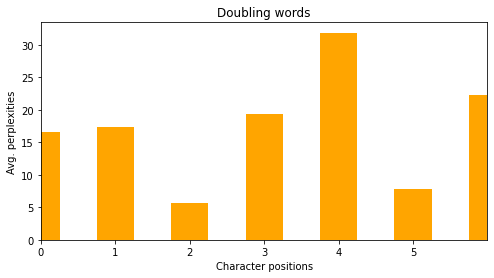

In [ ]:
# get the perpelxity at each character position (averaged over each doubling word)
# avgs_doubling = {}
# for batch, char_dict in position_perplexities_doubling.items():
#     for ch, p in char_dict.items():
#         if avgs_doubling.get(ch):
#             avgs_doubling[ch] += p
#         else:
#             avgs_doubling[ch] = p
# avgs_doubling = {k: v / 20 for k, v in avgs_doubling.items()}

# # plot
# df_doubling = pd.DataFrame(list(avgs_doubling.items()), columns=['Character Positions', 'doubling']) 
# plt.bar(df_doubling['Character Positions'], df_doubling['doubling'], color='orange', width=0.5)
# plt.title('Doubling words')
# plt.xlabel('Character positions')
# plt.ylabel('Avg. perplexities')
# plt.xlim(0,6)
# plt.xticks(np.arange(0, 6, 1))
# plt.rcParams["figure.figsize"] = (8, 4)
# plt.show()
# print('\n')

# Each word should have high perplexity in the begining, because the more 
# observations that a model sees, the less "perlexed" it will be, and it has
# observed little in the beginning of the word. However, I would guess that
# for doubling words, the model would get more perplexed towards the end
# of the word as well, when the doubling occurs, as that is not expected.
# On the other hand, I would expect perplexity to go down later in the word
# for words without doubling. 

Evaluate the model using non-words that do not have doubling. The perplexity of these words should be similar to that of actual English words.

In [104]:
# test control words (non-words, no doubling)

model.load_state_dict(torch.load(train_state['model_filename']))

model = model.to(args.device)

dataset.set_split('no_doubling')
batch_generator = generate_batches(dataset, 
                                   batch_size=1, # we change the batch size to 1, since we don't have many words we are working with
                                   device=args.device)


running_acc = 0.
model.eval()

word_perplexities_control = OrderedDict() # maps words --> perplexity values
position_perplexities_control = OrderedDict()

for batch_index, batch_dict in enumerate(batch_generator):

    # compute the output
    y_pred = model(x_in=batch_dict['x_data'])

    # initialize dictionary
    word_perplexities_control[batch_index] = OrderedDict()
    position_perplexities_control[batch_index] = OrderedDict()

    # iterate over each word in the batch, and calculate the loss for that word
    # save perplexity to dict
    start = 0
    end = 1
    for i in range(1):
        position_perplexities_control[batch_index][i] = OrderedDict()
        word_loss = sequence_loss(y_pred[start:end,:],batch_dict['y_target'][start:end,:], mask_index)

        # reconstruct the word and pp at each char posiiton
        word = ""
        start_pos = 0
        end_pos = 1
        for j in range(20):
            curr_char_index = batch_dict['y_target'][i][j].item()
            curr_char = vectorizer.char_vocab._idx_to_token[curr_char_index]
            if curr_char_index >= 4:
                word += curr_char

            position_loss = sequence_loss(y_pred[:, start_pos:end_pos],batch_dict['y_target'][:, start_pos:end_pos], mask_index)
            position_pp = math.pow(2,position_loss)
            position_perplexities_control[batch_index][i][(j,curr_char)] = position_pp
            start_pos += 1
            end_pos += 1

        pp = math.pow(2,word_loss)
        word_perplexities_control[batch_index][word] = pp

        start += 1
        end += 1

    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

    # compute the accuracy
    running_loss += (loss.item() - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc

In [105]:
# print the loss, perplexity, and accuracy for the doubling set overall
print("Test loss: {};".format(train_state['test_loss']))
print("Test perplexity: {};".format(math.pow(2,train_state['test_loss'])))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 2.8568397453853067;
Test perplexity: 7.2442671260070695;
Test Accuracy: 14.642857142857142


In [106]:
# print the perplexities for each word
for b, w_dict in word_perplexities_control.items():
    for w, p in w_dict.items():
        print("word: ", w, " perplexity: ", round(p,2))

word:  plonmuk  perplexity:  10.22
word:  smatnod  perplexity:  7.99
word:  slodmog  perplexity:  8.75
word:  klenmof  perplexity:  11.79
word:  draknad  perplexity:  7.11
word:  freblek  perplexity:  7.33
word:  praflak  perplexity:  6.07
word:  trosnot  perplexity:  5.95
word:  kravmal  perplexity:  7.95
word:  snadmak  perplexity:  11.84
word:  slanmot  perplexity:  5.78
word:  flakmal  perplexity:  8.11
word:  flamrad  perplexity:  6.25
word:  plafnut  perplexity:  6.87
word:  franmet  perplexity:  4.98
word:  smolrog  perplexity:  8.11
word:  klopnog  perplexity:  7.59
word:  blafron  perplexity:  7.08
word:  tramlut  perplexity:  7.08
word:  froslak  perplexity:  6.84
word:  snogmot  perplexity:  8.14
word:  granlat  perplexity:  5.85
word:  kragnel  perplexity:  7.29
word:  greflek  perplexity:  6.04
word:  flonmog  perplexity:  7.99
word:  trelnat  perplexity:  4.96
word:  flibnep  perplexity:  7.37
word:  dranlat  perplexity:  4.63
word:  traflam  perplexity:  6.63
word:  grof

In [109]:
s_words_control = []
for b, w_dict in word_perplexities_control.items():
    for w, p in w_dict.items():
        temp = [w,p]
        s_words_control.append(temp)
s_words_control_df = pd.DataFrame(s_words_control, columns = ['word', 'perplexity'])
s_words_control_df.to_csv("/content/drive/MyDrive/Lang-and-Mind-Lab/control_word_pp.csv", sep=",", header=True)

In [110]:
# save pp for each char of each word to file
s_chars_control = []
for b, w_dict in position_perplexities_control.items():
    for w, char_dict in w_dict.items():
        temp = [w]
        for ch, p in char_dict.items():
            temp.append((ch,p))
        s_chars_control.append(temp)

s_chars_control_df = pd.DataFrame(s_chars_control)
s_chars_control_df.to_csv("/content/drive/MyDrive/Lang-and-Mind-Lab/control_char_pp.csv", sep=",", header=True)

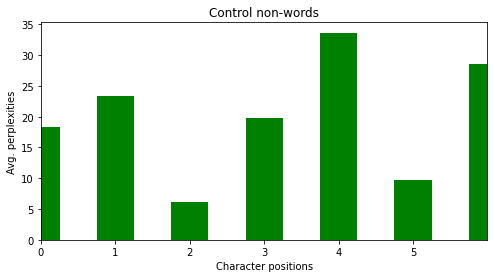

In [ ]:
# # get the perpelxity at each character position (averaged over each non-doubling word)
# avgs_control = {}
# for batch, char_dict in position_perplexities_control.items():
#     for ch, p in char_dict.items():
#         if avgs_control.get(ch):
#             avgs_control[ch] += p
#         else:
#             avgs_control[ch] = p
# avgs_control = {k: v / 20 for k, v in avgs_control.items()}

# # plot
# df_control = pd.DataFrame(list(avgs_control.items()), columns=['Character Positions', 'control']) 
# plt.bar(df_control['Character Positions'], df_control['control'], color='green', width=0.5)
# plt.title('Control non-words')
# plt.xlabel('Character positions')
# plt.ylabel('Avg. perplexities')
# plt.xlim(0,6)
# plt.xticks(np.arange(0, 6, 1))
# plt.rcParams["figure.figsize"] = (8, 4)
# plt.show()
# print('\n')

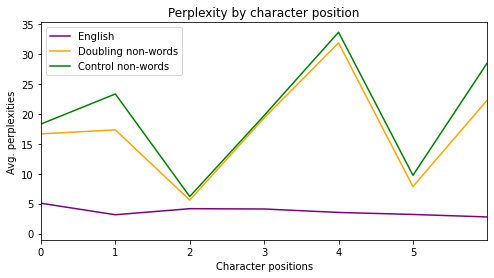

In [ ]:
# plot English test words, doubling non-words, and control non-words together
# # combined plot
# df_doubling_pp = df_doubling["doubling"]
# df_control_pp = df_control["control"]
# all_data = df.join(df_doubling_pp)
# all_data = all_data.join(df_control_pp)
# plt.plot(all_data["English"], label='English', color="purple")
# plt.plot(all_data["doubling"], label='Doubling non-words', color="orange")
# plt.plot(all_data["control"], label='Control non-words', color="green")
# plt.title('Perplexity by character position')
# plt.xlabel('Character positions')
# plt.ylabel('Avg. perplexities')
# plt.legend()
# plt.xlim(0,6)
# plt.xticks(np.arange(0, 6, 1))
# plt.show()

# Generate new words

We can have the model generate words, and count the words that have doubling in them (a model that has learned English well, would not have many words with doubling?)

In [ ]:
# number of names to generate
num_words = 20
model = model.cpu()
# Generate nationality hidden state
sampled_words = decode_samples(
    sample_from_model(model, vectorizer, num_samples=num_words), 
    vectorizer)
# Show results
print ("-"*15)
for i in range(num_words):
    print (sampled_words[i])

---------------
lecaderLrmecs
accoccuytal
dilire
rofamict
obmcnecrieds
bummere
des
mipt
abhl
palfes
pxlure
icolic
pbor
wanyac
atibakiud
hnakul
benlexs
detons
arfhion
cenpimalemer
